# Uso de Redes Neuronales Profundas para detectar URL's maliciosos
## Por: Oswaldo Alan Vergara Eslava
### Creado el 8 de abril del 2025

Se importan las librerías necesarias para el proyecto

In [2]:
#Lectura y tratamiento de datos
import pandas as pd
import numpy as np

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#modelos
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

Se leen los datos "Malicious-URLs.csv", obtenido desde el repositorio de [Kaggle](https://www.kaggle.com/datasets/himadri07/malicious-urls-dataset-15k-rows?resource=download).

In [4]:
#Especificar la ruta del dataset
ruta="E:\Ciencia de Datos\Tareas\Malicious-URLs.csv"

df=pd.read_csv(ruta)
df.head()

<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\osvic\AppData\Local\Temp\ipykernel_16176\3151149315.py:2: SyntaxWarning: invalid escape sequence '\C'
  ruta="E:\Ciencia de Datos\Tareas\Malicious-URLs.csv"


,Unnamed: 0,url,type
0,0,br-icloud.com.br,phishing
1,1,mp3raid.com/music/krizz_kaliko.html,benign
2,2,bopsecrets.org/rexroth/cr/1.htm,benign
3,3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,4,http://adventure-nicaragua.net/index.php?optio...,defacement


Se divide la base de datos en las columnas de URL's y su clasificación

In [5]:
url=df["url"].astype(str)
type=df["type"]

Se puede notar que la base de datos cuenta únicamente con caracteres alfanuméricos y especiales, por lo que un modelo de Redes Neuronales Recurrentes (RNN) óptimo para el tratamiento de estos caracteres sería LSTM(Long Short-Term Memory). Una buena forma de tratar con estos datos es haciéndoles una "traducción" a vectores numéricos con una codificación. 

Las URL's se traducirán a vectores, por lo que se debe tener en cuenta de que todos los vectores deben de ser de la misma dimensión antes de ser tratados mediante el modelo LSTM.

Las etiquetas **benign, defacement, phishing y malware**, se utilizarán números del 0 al 4 para darles una clasificación. 

In [6]:
tokenizer = Tokenizer(char_level=True)   #char_level=true hace que se puedan interpretar caracteres especiales como /,-,_,=...
tokenizer.fit_on_texts(url)

#Se convierte cada URL en una secuencia
url_sec=tokenizer.texts_to_sequences(url)

#Y se rellenan los espacios faltantes de las URL's "pequeñas". PE: una URL de 10 caracteres tendrá una dimensión menor que una de 50 caracteres
maxlen=max(len(seq) for seq in url_sec)
X=pad_sequences(url_sec, maxlen=maxlen, padding="post")   #pad_sequences rellena con ceros al final (padding="post") de las URL's

#miramos las primeras dos secuencias
X[:2]

array([[20,  9, 15,  5,  8, 12,  2, 19, 16, 13,  8,  2, 11, 13, 20,  9,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [11, 14, 33,  9,  4,  5, 16, 13,  8,  2, 11,  6, 11, 19, 10,  5,
         8,  6, 27,  9,

En este primer enfoque se tratan las etiquetas de **defacement, phishing y malware** como etiquetas individuales entre sí, de modo que el modelo intentará predecir individualmente si un link es **benign, defacement, phishing o malware**. 

In [7]:
Y=type.map({"benign":0, "defacement":1,"phishing":2, "malware":3}).values

Se separan los datos de entrenamiento y prueba, y se construye el modelo LSTM

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

vocab_size=len(tokenizer.word_index) + 1  # número total de caracteres + 1 para ceros rellenados
embedding_dim=32                          # tamaño del vector que representará cada carácter
input_length=X.shape[1]                   # longitud de todas las secuencias tras haber rellenado con ceros

model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(4, activation="softmax"))
model.build(input_shape=(None, input_length))

model.compile(optimizer=Adam(learning_rate=0.01), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'],                   #Muestra la precisión durante el entrenamiento
             )
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 32)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 200, 100)       │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,948 (534.95 KB)

 Trainable params: 136,948 (534.95 KB)

 Non-trainable params: 0 (0.00 B)

Se entrena al modelo en 50 épocas mientras se muestra la información de precisión (accuracy), pérdida (loss) y sus respectivas validaciones

In [11]:
# Entrenar el modelo
history=model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.15) #15% de datos de validación

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - accuracy: 0.7310 - loss: 0.7893 - val_accuracy: 0.7383 - val_loss: 0.7117
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 59s 184ms/step - accuracy: 0.7400 - loss: 0.6724 - val_accuracy: 0.8539 - val_loss: 0.5007
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 56s 177ms/step - accuracy: 0.8539 - loss: 0.4676 - val_accuracy: 0.8694 - val_loss: 0.4311
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 56s 174ms/step - accuracy: 0.8757 - loss: 0.3984 - val_accuracy: 0.8700 - val_loss: 0.4046
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 59s 184ms/step - accuracy: 0.8874 - loss: 0.3593 - val_accuracy: 0.8989 - val_loss: 0.2709
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 64s 202ms/step - accuracy: 0.8927 - loss: 0.3289 - val_accuracy: 0.9533 - val_loss: 0.1683
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 67s 210ms/step - accuracy: 0.9383 - loss: 0.1939 - val_accuracy: 0.9550 - val_loss: 0.1542
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 67s 208ms/step - accuracy: 0.9378 - loss: 0

Se mide la precisión del modelo entrenado

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Precisión del test: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9670 - loss: 0.1168
Precisión del test: 0.9653


Se observan los valores que ha predicho el modelo, recordando que benign:0, defacement:1, phishing:2 y malware:3

In [13]:
#predicciones del modelo
Y_pred_probs=model.predict(X_test)         #probabilidades
Y_pred=np.argmax(Y_pred_probs, axis=1)     #Probabilidades->Clase predicha
Y_pred

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step


array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

Se grafica la presición del modelo durante el entrenamiento y su función de pérdida con sus respectivas validaciones. Una subida rápida en la precisión (**accuracy**) y una bajada rápida en la función de pérdida (**loss**) indica que el modelo aprendió muy rápido, tan solo dentro de las primeras 10 épocas, el hecho de que se mantengan estables después de esos cambios nos indica que el modelo generaliza bien, y tomando en cuenta que las lineas de **accuracy** y **loss** siguen muy de cerca a sus respectivas validaciones indica que el modelo no tiene **overfitting**

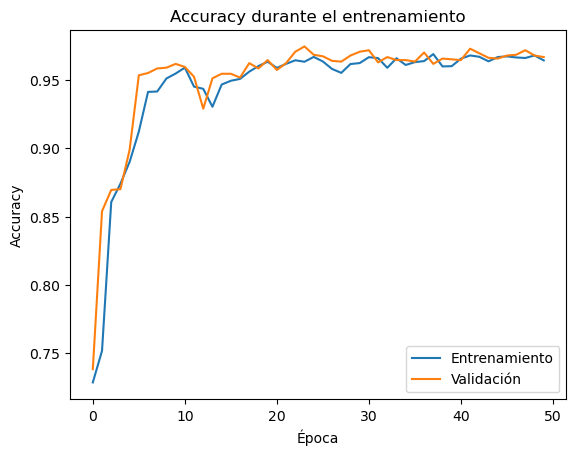

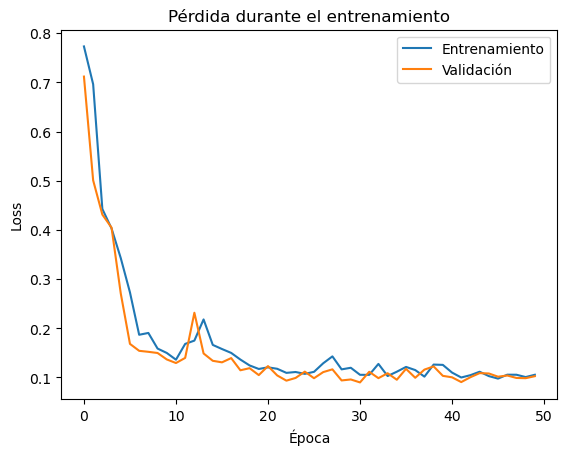

In [15]:
# Accuracy
plt.plot(history.history["accuracy"], label='Entrenamiento')
plt.plot(history.history["val_accuracy"], label='Validación')
plt.title("Accuracy durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


En la matriz de confusión se puede observar que el modelo predice con alta precisión cuando un link es **benign**, **defacement** o **phishing**, siendo su punto más débil el encontrar **malware**. Sin embargo, en términos prácticos puede ser más interesante no caer en un link que encaje en cualquiera de los tres de tipo malicioso, y es ahí donde encontramos muy pocas predicciones erroneas al encontrar links **malignos** como si fuesen **benignos**

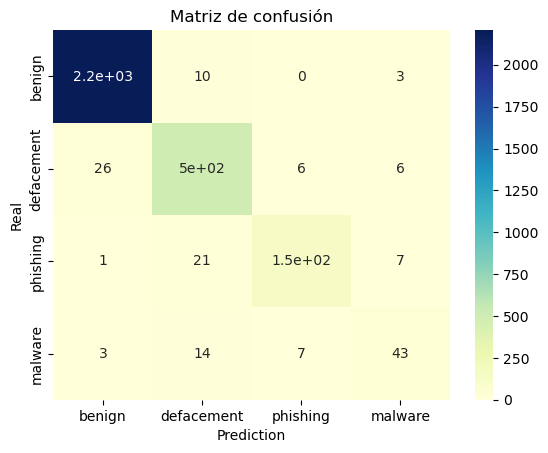

Reporte de Clasificación:
              precision    recall  f1-score   support

      benign       0.99      0.99      0.99      2220
  defacement       0.92      0.93      0.92       538
    phishing       0.92      0.83      0.87       175
     malware       0.73      0.64      0.68        67

    accuracy                           0.97      3000
   macro avg       0.89      0.85      0.87      3000
weighted avg       0.96      0.97      0.96      3000



In [16]:
#Matriz de Confusión
cm=confusion_matrix(y_test, Y_pred)
labels=["benign", "defacement", "phishing", "malware"]

#Mapa de calor
sns.heatmap(cm,cmap="YlGnBu", xticklabels=labels, yticklabels=labels,annot=True)
plt.title("Matriz de confusión")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.show()

print("Reporte de Clasificación:")
print(classification_report(y_test, Y_pred, target_names=labels))